In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as LSC
from matplotlib.lines import Line2D
from matplotlib.patches import Wedge
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
df = pd.read_csv("op_art.csv", index_col=0)
df['value'] = .1 + np.log(df['sum'])
df.head(2)

,slug,bucketMonthly,sum,value
0,0x-splits,2022-10-01,68.0,4.319508
1,0x-splits,2023-02-01,5.0,1.709438


In [3]:
font_family = "PT Mono"
background_color = "#F8F1F1"
text_color = "#040303"
OP_RED = "#FF0420"

sns.set_style({
    "axes.facecolor": background_color,
    "figure.facecolor": background_color,
    "font.family": font_family,
    "text.color": text_color,
})

In [4]:
SLUGS = len(df['slug'].unique())
SLUGS

221

In [5]:
MONTHS = sorted(df['bucketMonthly'].unique())
len(MONTHS)

25

In [6]:
NROWS = 5
NCOLS = 5

# 1/ Polar Optimist

- Each project is a unique wedge
- Bar height = log transactions for that project
- One plot per month

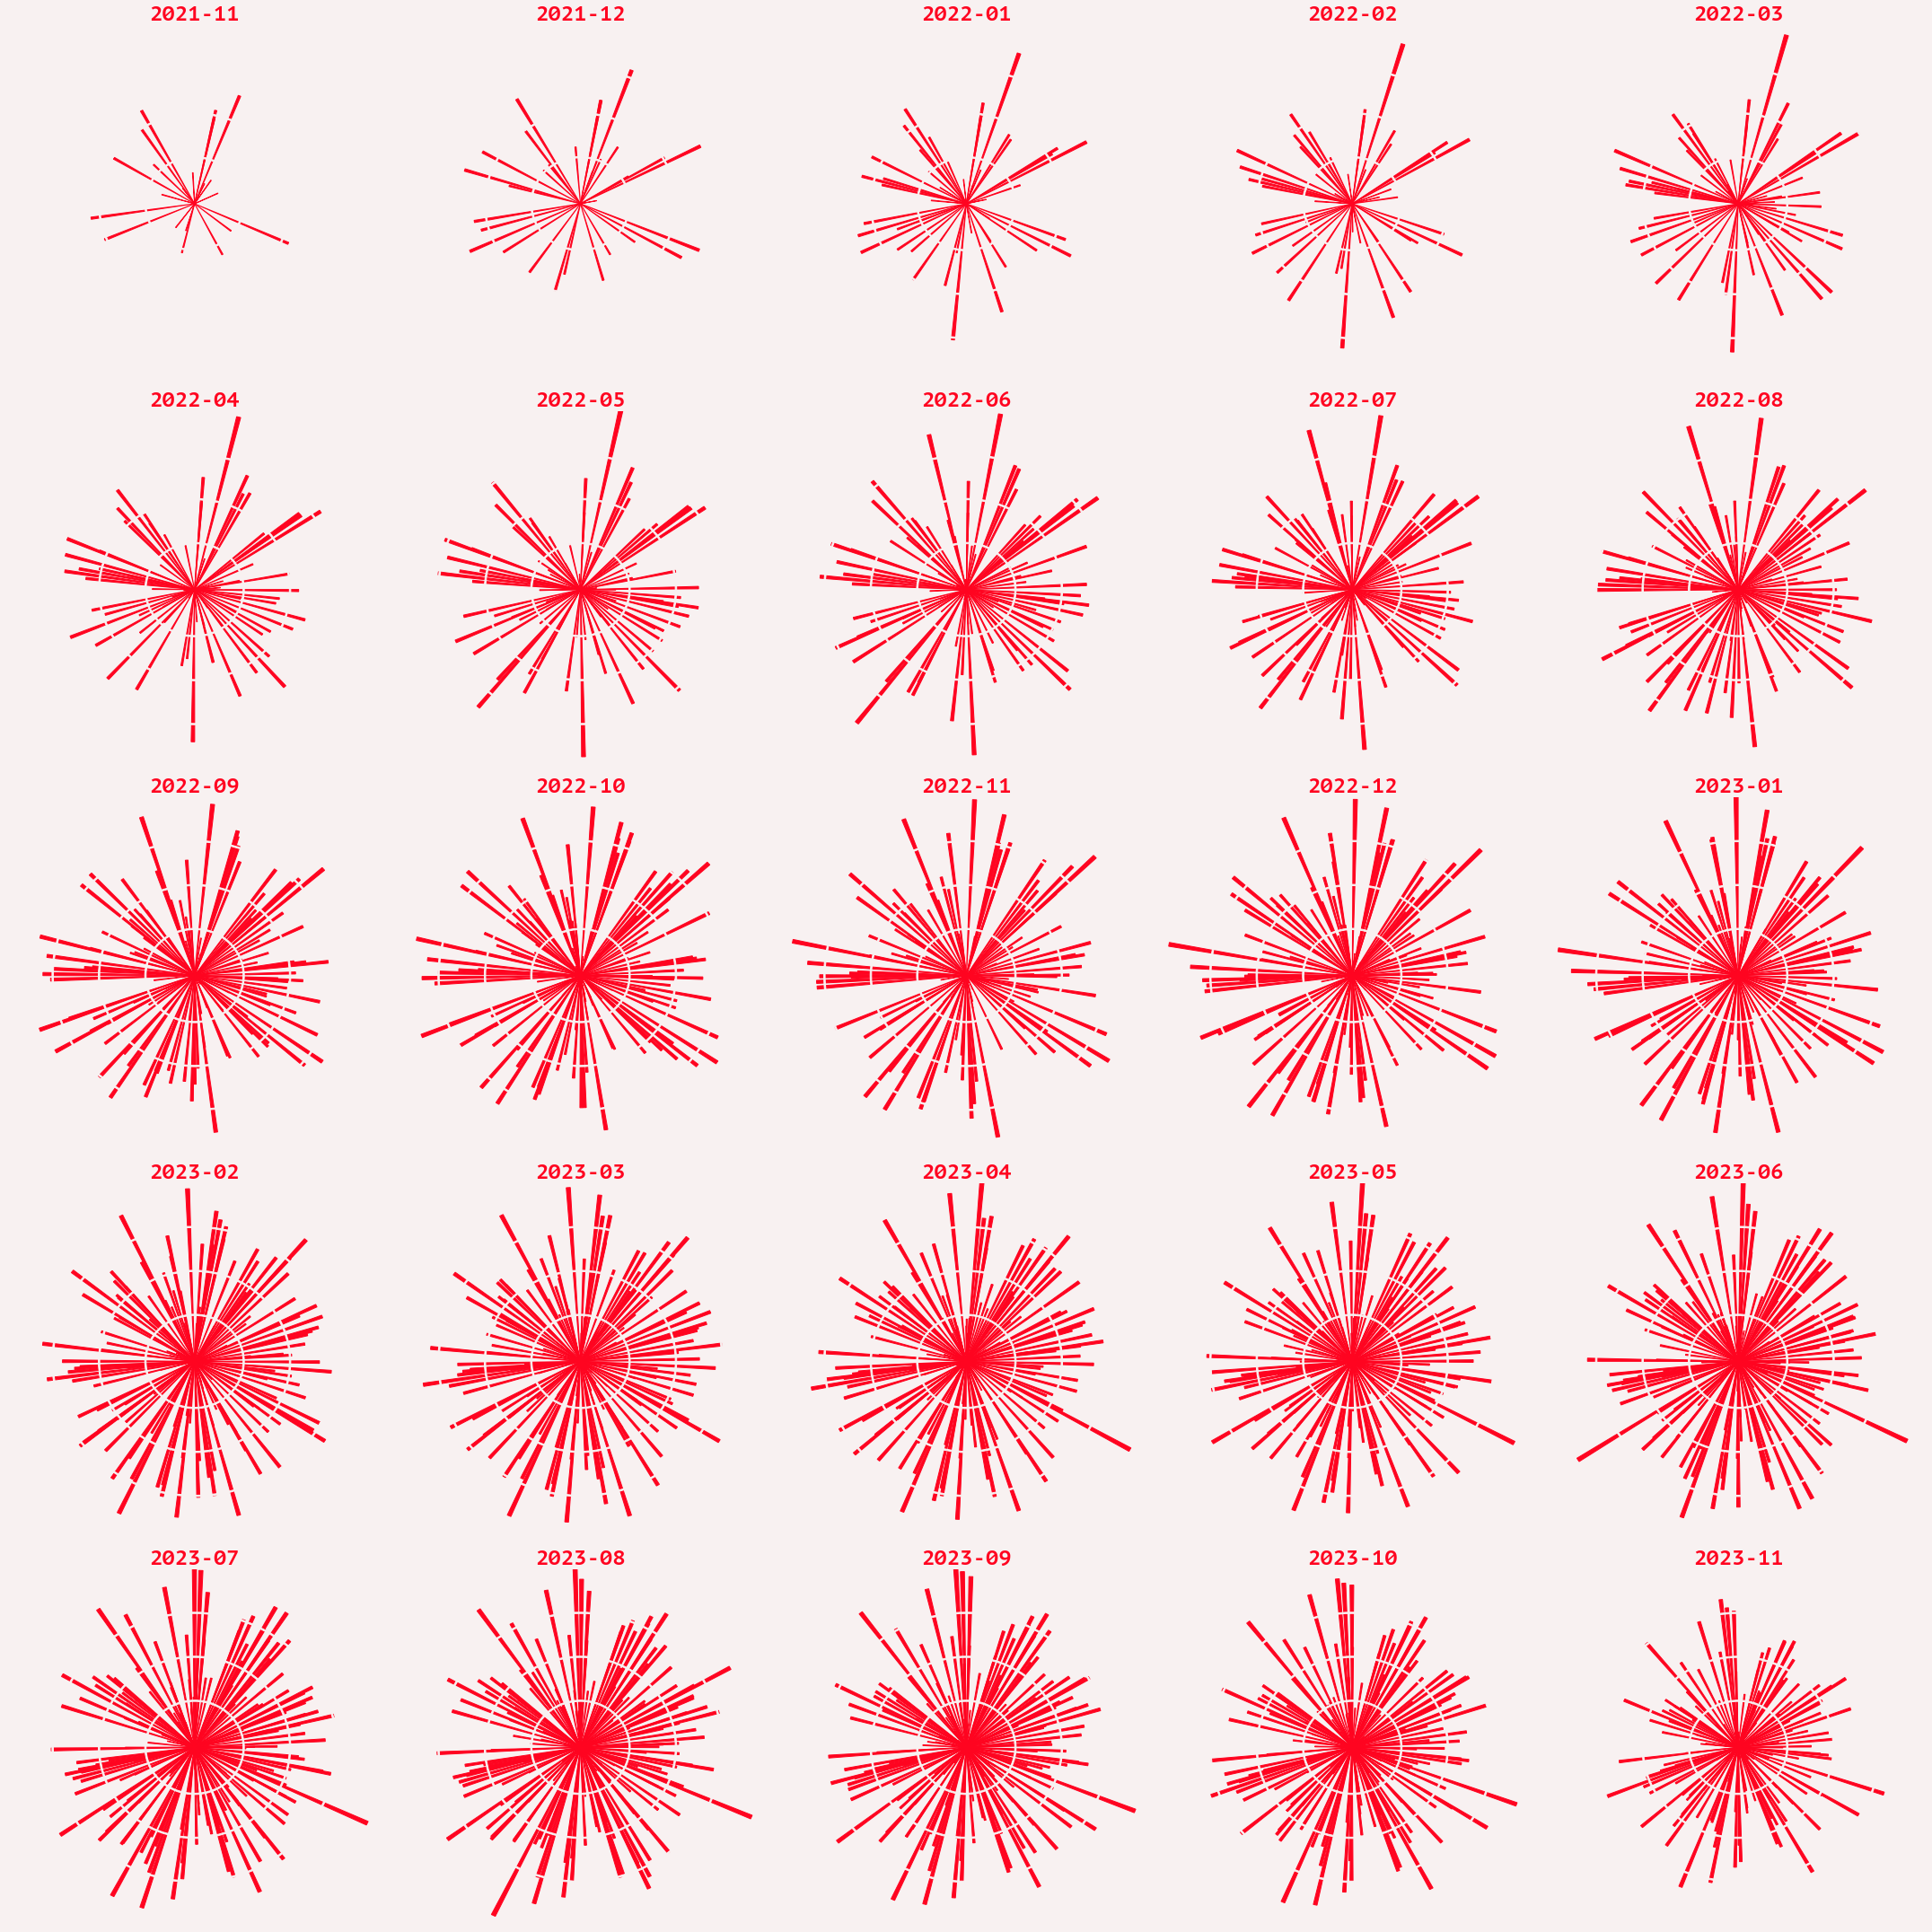

In [7]:
def draw_wedge(ax, start_angle, end_angle, length, bar_length, color):
    ax.add_artist(
        Wedge((0, 0),
            length, start_angle, end_angle, color=color, width=bar_length
        )
    )
    
  
def make_subplot(dff, ax, title=None):
    
    def draw_reference_line(ax, point, size, padding, fontsize=18):
        draw_wedge(ax, 0, 360, point+padding+size/2, size, background_color)
        
    start_angle = 100
    end_angle = 450

    size = (end_angle - start_angle) / SLUGS
    pad = 0.2 * size    
    inner_padding = 2 * df.value.min()
    limit = .9 * (inner_padding + df.value.max())
    
    ax.set(xlim=(-limit, limit), ylim=(-limit, limit))
    
    for i, row in dff.iterrows():
        bar_length = row.value
        name = row.slug
        length = bar_length + inner_padding
        start = 100 + i*size + pad
        end = 100 + (i+1)*size
        angle = (end + start) / 2

        bar_length = row.value
        length = bar_length
        start = 100 + i*size + pad
        end = 100 + (i+1)*size

        draw_wedge(ax, start, end, length, bar_length, OP_RED)  
        
    for i in range(3):
        draw_reference_line(ax, np.log(30**(i+1)), 0.1, inner_padding)
            
    ax.axis("off")
    if title:
        ax.set_title(title, loc='center', color=OP_RED, fontsize=24)
        
fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(30, 30))
for row in range(NROWS):
    for col in range(NCOLS):
        idx = 5*row + col
        dff = df[df['bucketMonthly'] == MONTHS[idx]]
        make_subplot(dff, axes[row][col], MONTHS[idx][:-3])
        
fig.tight_layout()
plt.show()                

# 2/ Top 42

- The top 42 projects (by txn count) have their own row
- Each bar is the log transactions for that month
- Color is a function of the mean transactions per month

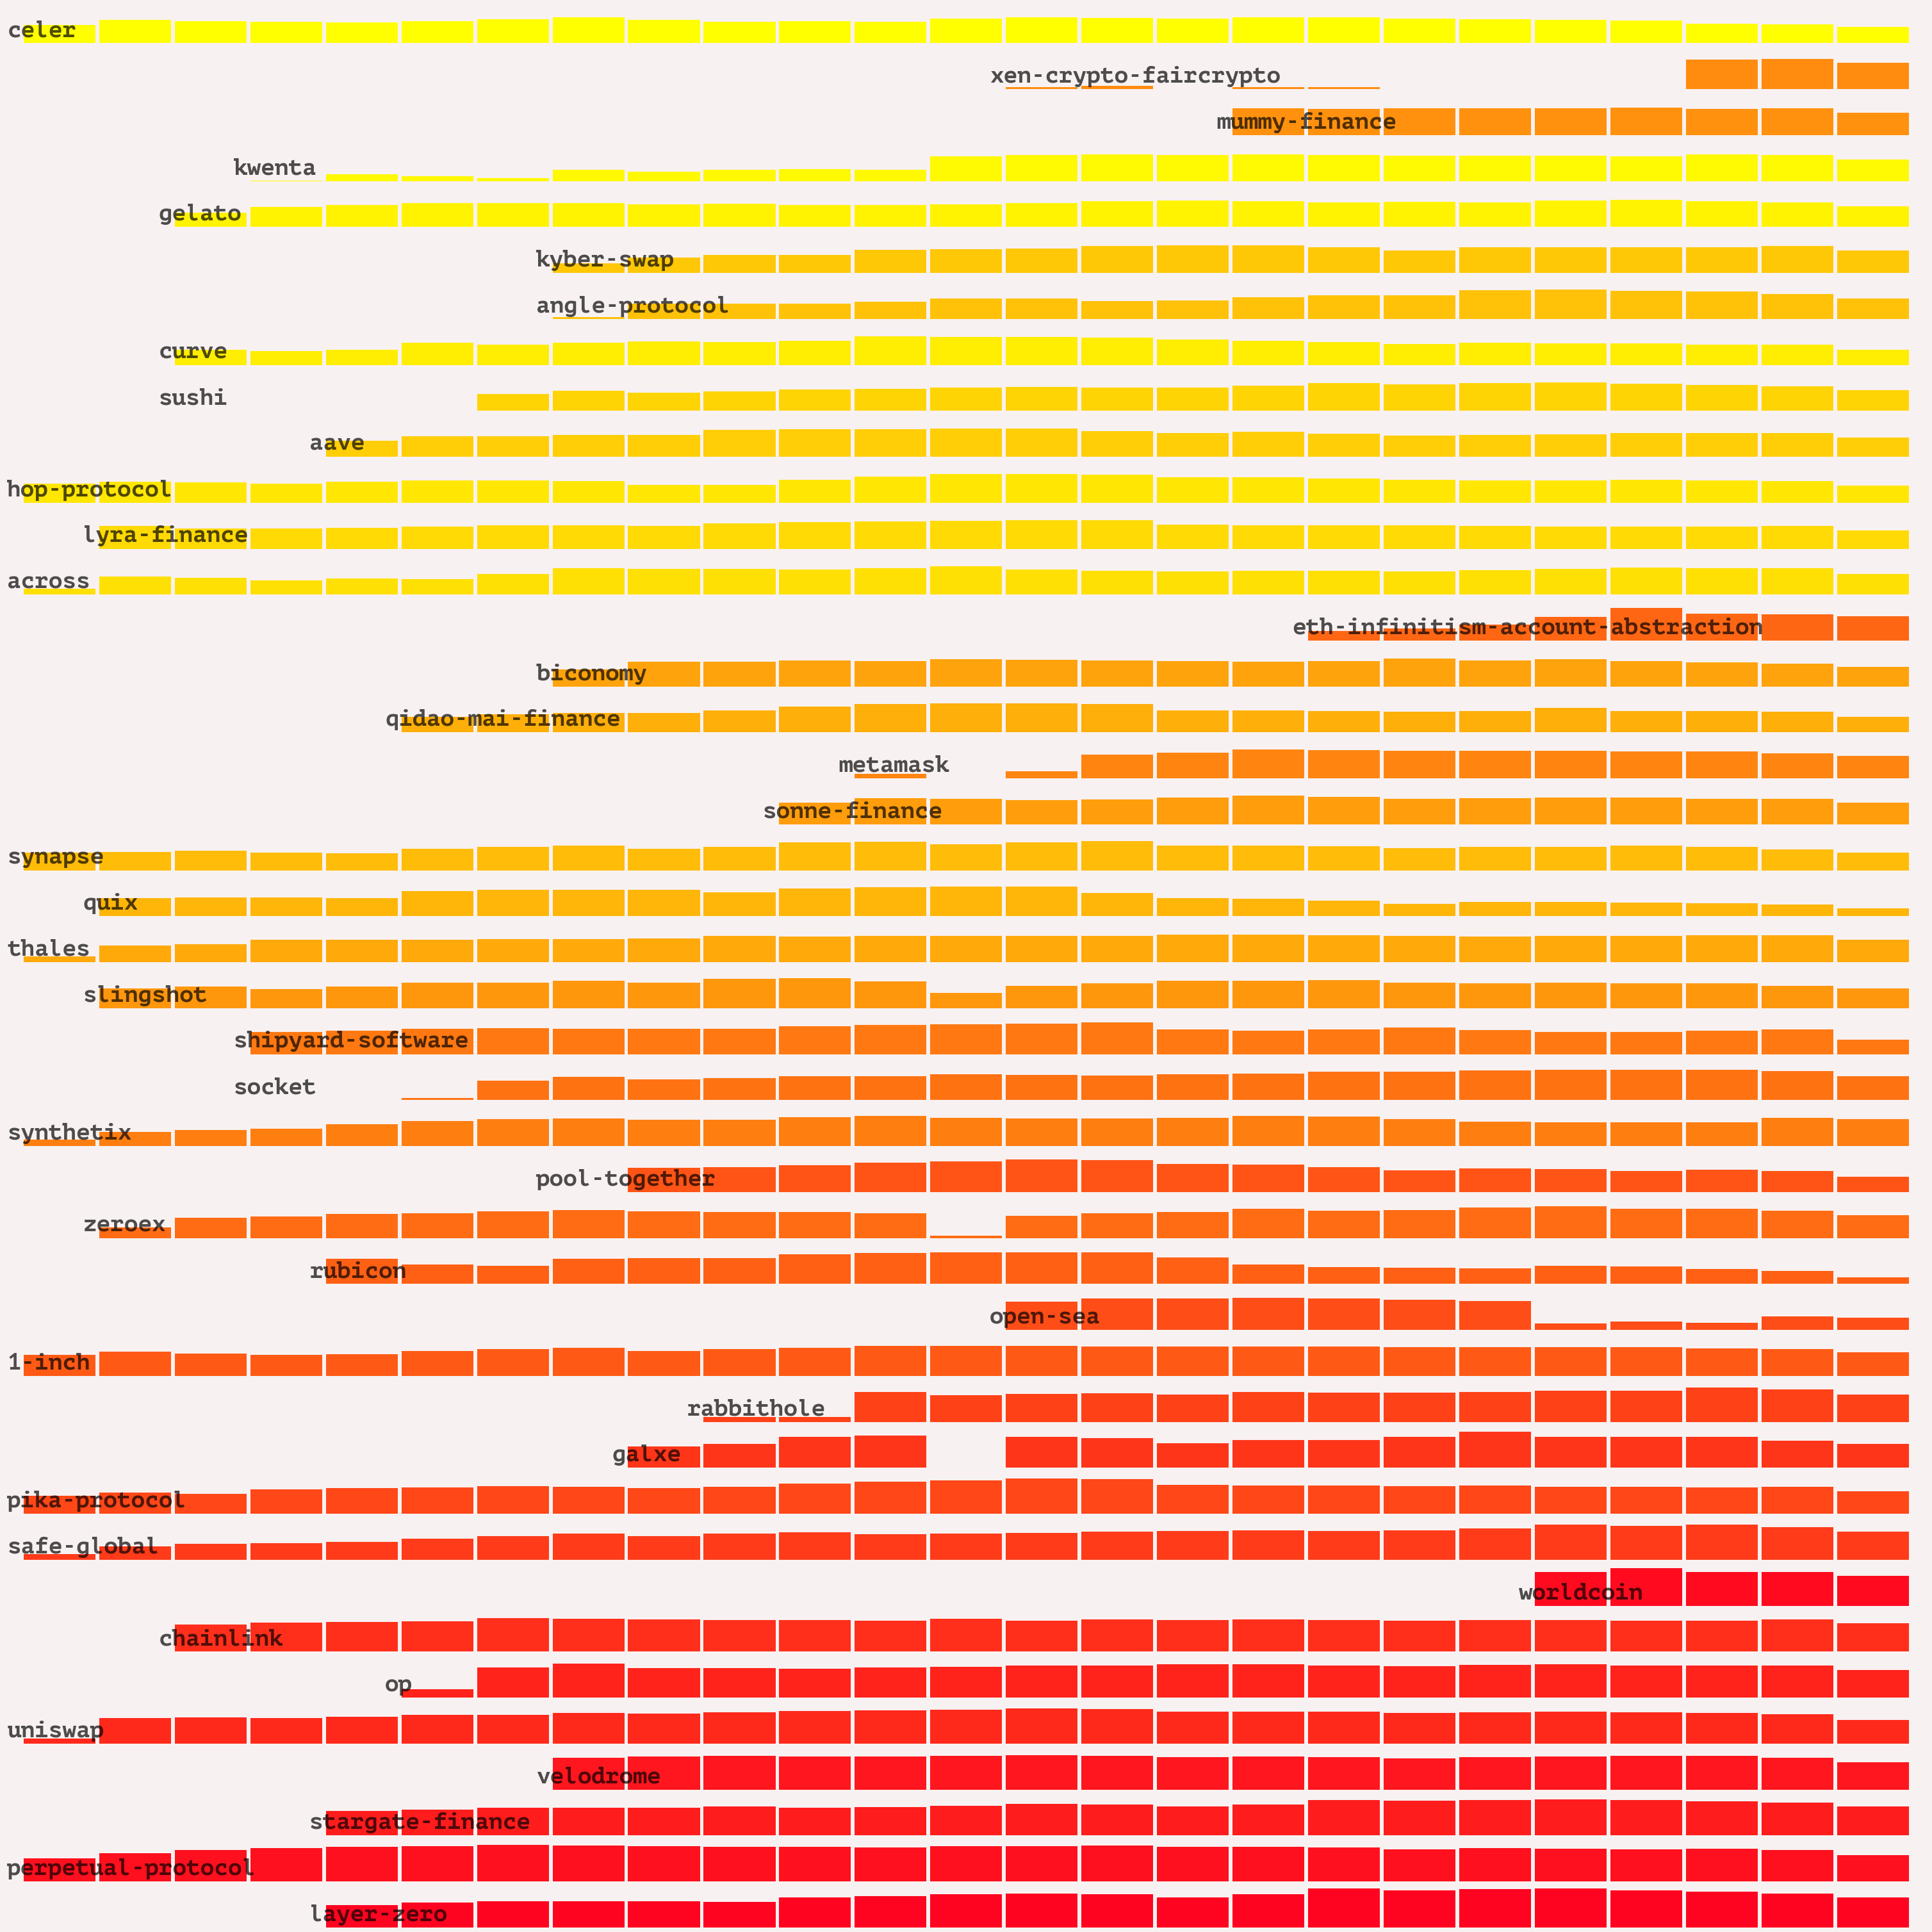

In [8]:
N = 42

cmap = LSC.from_list(name="OP", colors=["yellow", "#FF0420"], N=N)
top_projects = df.groupby('slug')['sum'].sum().sort_values().tail(N).index
max_val = df[df['slug'].isin(top_projects)]['value'].max()
pvt = df.pivot_table(index='slug', columns='bucketMonthly', values='value', fill_value=0)
color_rank = list(df[df['slug'].isin(top_projects)].groupby('slug')['sum'].mean().sort_values().index)

fig, axes = plt.subplots(nrows=N, ncols=1, figsize=(N, N))
for i in range(N):
    ax = axes[i]
        
    project = top_projects[i]
    series = pvt.loc[project]
    color = color_rank.index(project)
    
    series.plot(kind='bar', ax=ax, color=cmap(color), width=.95)
    ax.set_ylim(0,max_val)
    
    first_x = min([x for x,val in enumerate(series.values) if val > 0]) - .69
    ax.text(s=project, x=first_x, y=1, va='bottom', ha='left', color='black', fontsize=36, alpha=.69)
    ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)    
plt.tight_layout()
plt.show()            

# 3/ always stay optimistic

- One letter per subplot
- Color of the letter is a function of total transactions for that month (all projects)
- Opacity is a function of the total number of projects that had transactions that month

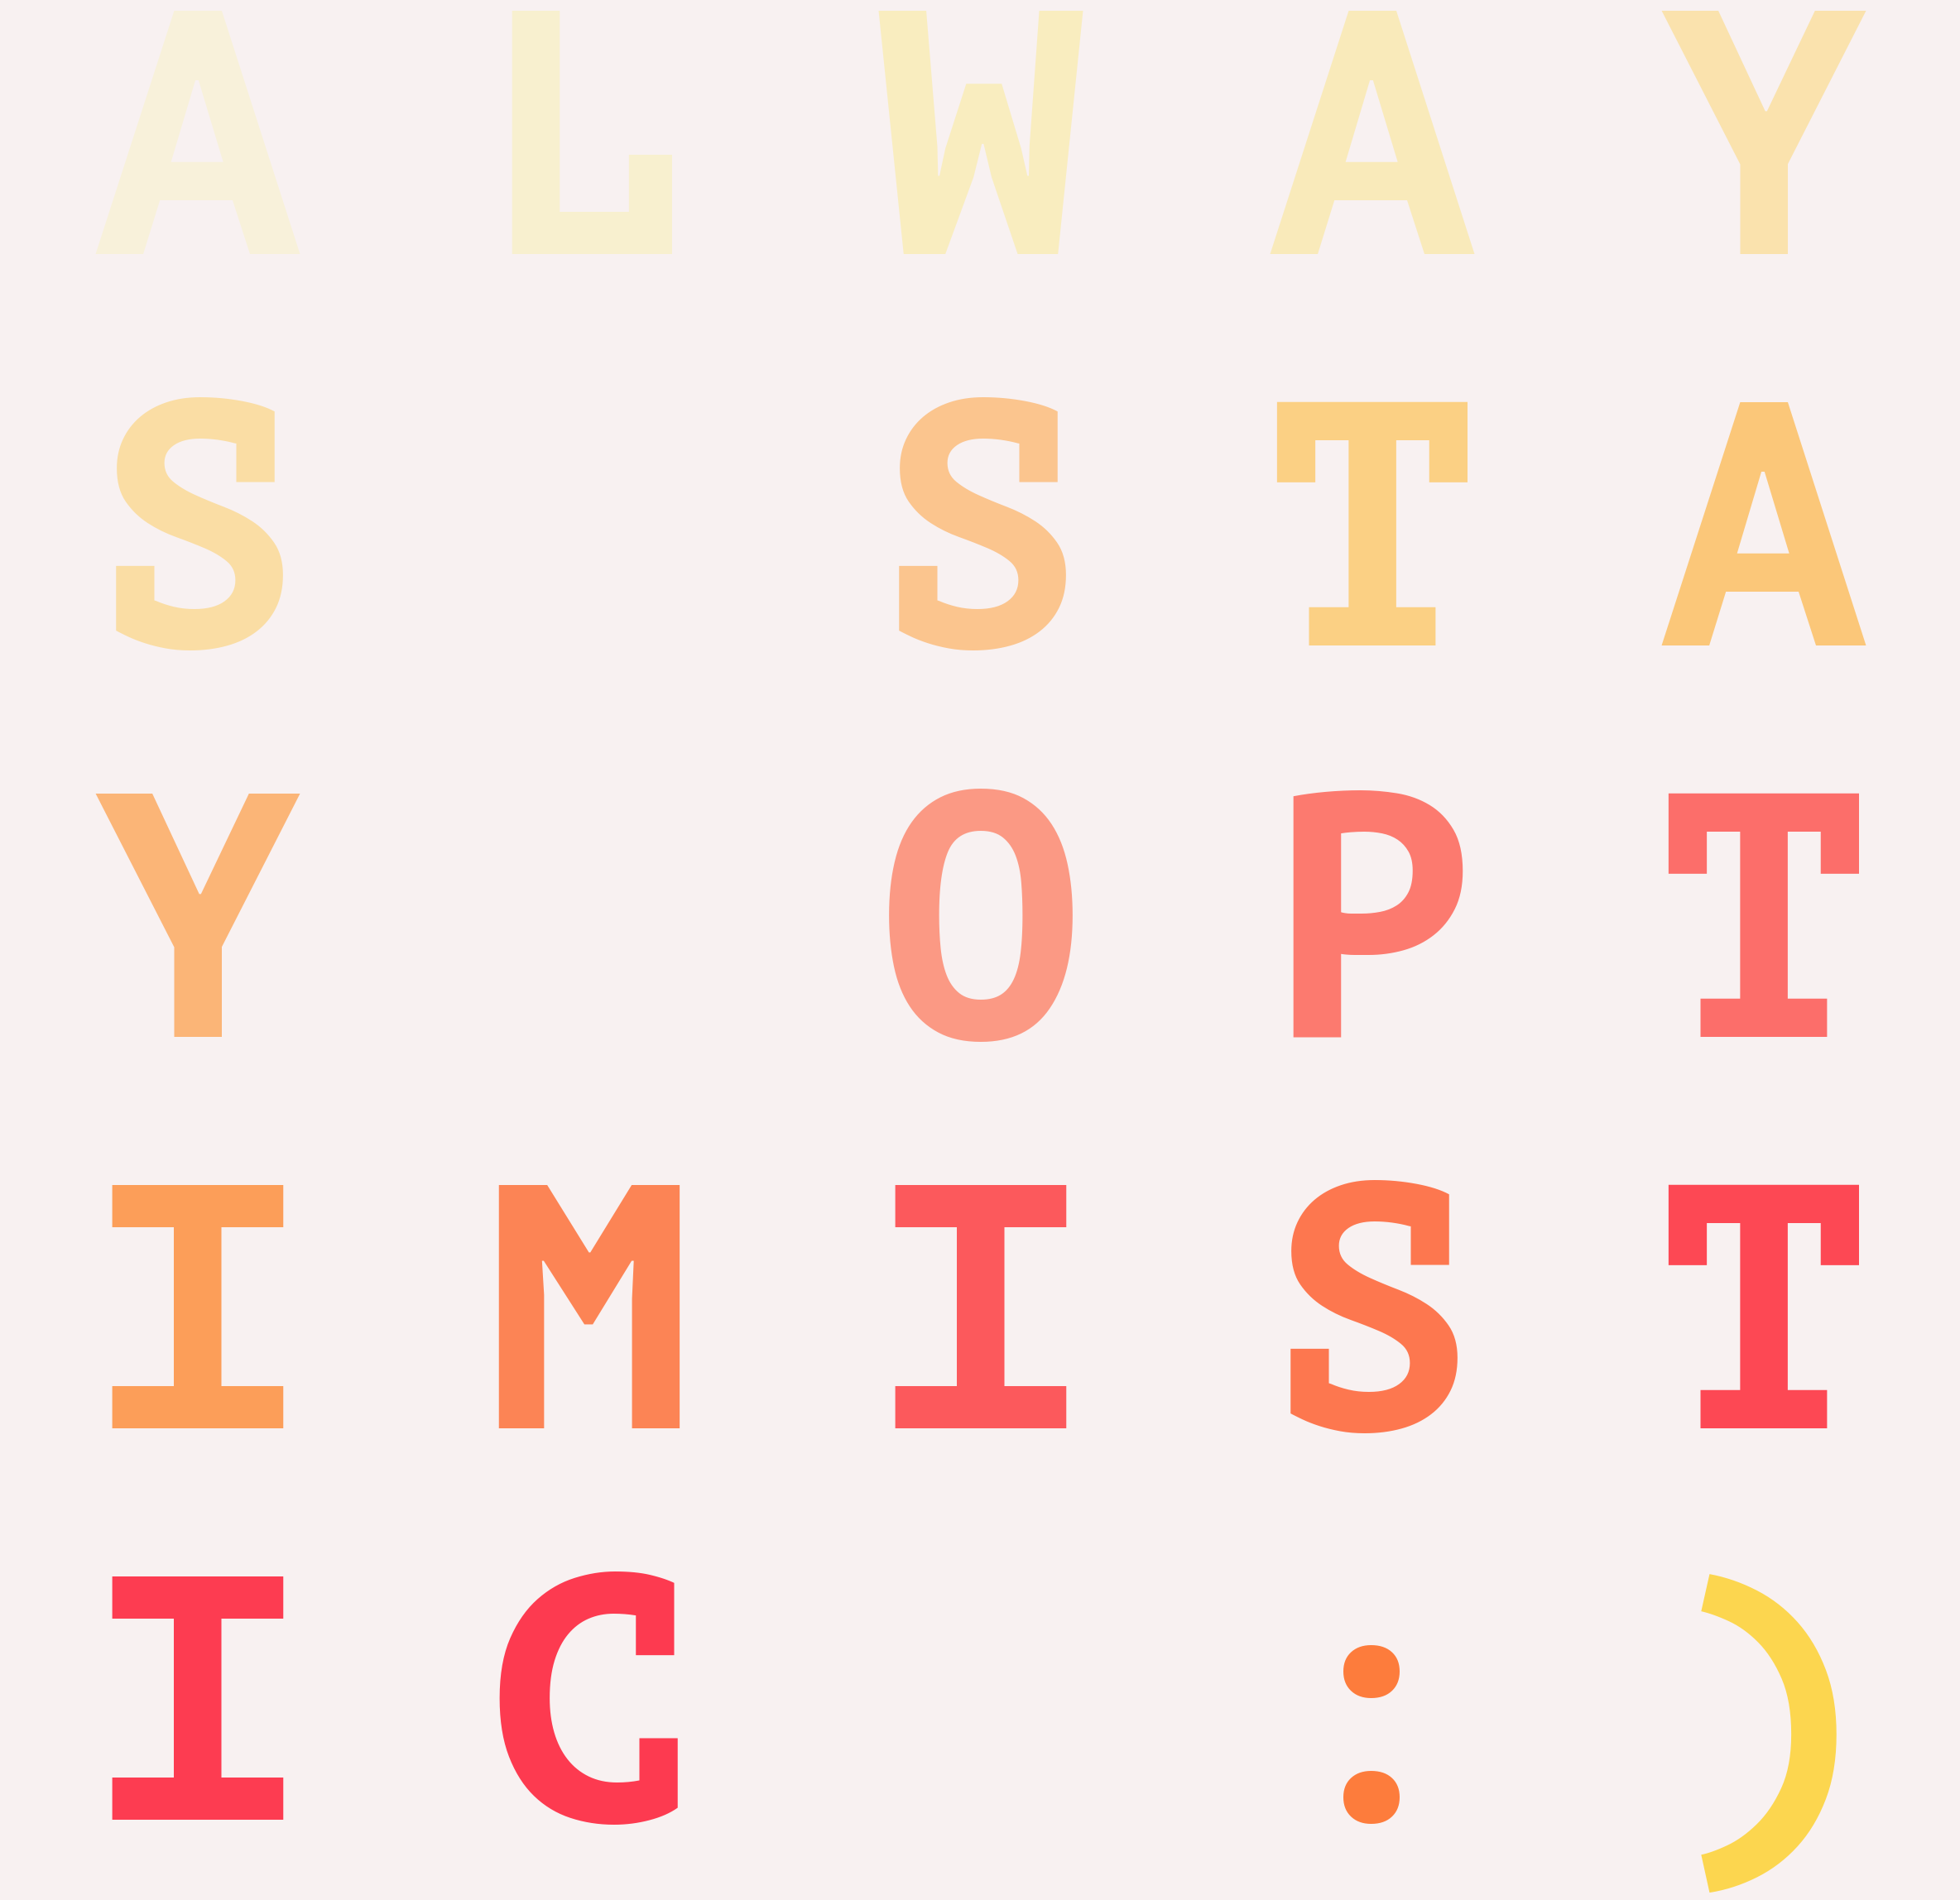

In [9]:
cmap = LSC.from_list(name="OP", colors=["yellow", "#FF0420"], N=len(MONTHS))
string = "always stay optimistic :)"

month_rank = list(df.groupby('bucketMonthly')['sum'].sum().rank())
num_projects = list(df.groupby('bucketMonthly')['slug'].nunique())

fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(33, 33))

for row in range(NROWS):
    for col in range(NCOLS):
        idx = row*NCOLS + col
        color = int(month_rank[idx])
        ax = axes[row][col]
        ax.text(
            s=string[idx].title(), 
            x=.5, 
            y=.5, 
            color=cmap(color), 
            alpha=num_projects[idx]/SLUGS, 
            fontsize=420, 
            ha='center', 
            va='center', 
            fontstyle='italic'
        )
        ax.axis("off")
        
fig.tight_layout()
plt.show()        